In [1]:
from plotModule import *
from preprocessModule import *
from meta_data import * 

### Load

In [2]:
data_type = "fftMap" #"fd"
dataset = "DEAP" # "SEED"
split = "10sec_9over"

In [3]:
if dataset == "SEED":
    def get_data_index(p_id, t_id, c_id, noc=0):
        return ptc_to_idx[str(p_id+1) + "-" + str(t_id) + "-" + str(c_id)]
    def get_base_index(p_id, t_id):
        return 15 * p_id + t_id
    # get p_id, t_id, c_id
    def from_data_index(index, noc=0):
        return idx_to_ptc[index]
    
elif dataset == "DEAP":
    def get_data_index(p_id, t_id, c_id, noc=1):
        return (noc * 40) * p_id + noc * t_id + c_id
    def get_base_index(p_id, t_id):
        return 40 * p_id + t_id
    def from_data_index(index, noc=1):
        # return index//40, index%40
        p_id,remain = index // (noc*40), index % (noc*40)
        return p_id, remain//noc, remain%noc

In [4]:
import pickle

# load base data list (if needed) ========
# base_path = dataset + "_" + data_type + "_base.pickle"
# with open(base_path, 'rb') as f:
#     base_list = pickle.load(f)
# ========================================

# load activated data list================
data_path = dataset + "_" + data_type + "_" + split + ".pickle"

with open(data_path, 'rb') as f:
    data_list = pickle.load(f)
# ========================================

# load meta data(index file) =============
if dataset == "SEED":
    noc = 0 # not used
    with open("SEED_10sec_5over_ptc_to_idx", 'rb') as f:
        ptc_to_idx = pickle.load(f)

    with open("SEED_10sec_5over_idx_to_ptc", 'rb') as f:
        idx_to_ptc = pickle.load(f)
        
elif dataset == "DEAP":
    noc = len(data_list)//1280
# ========================================

In [5]:
if dataset == "SEED":
    channels = SEED_channels
elif dataset == "DEAP":
    channels = DEAP_channels
all_channel_names = list(channels.keys())
all_channel_values = list(channels.values())

chosen_channels = all_channel_values

# openBCI default channels 
# chosen_channel_names = ["FP1", "FP2", "C3", "C4", "P7", "P8", "O1", "O2"]
# chosen_channels = []
# for ch_name in chosen_channel_names:
#     chosen_channels.append(channels[ch_name])

### Selection plot

In [6]:
# choose participants and trials
p_ids = [4,5,6]
t_ids = [0,1,2]
idx_list = [get_data_index(p_ids[0],t_ids[0], 0, noc),get_data_index(p_ids[0], t_ids[1], 0, noc),get_data_index(p_ids[0], t_ids[2], 0, noc),
            get_data_index(p_ids[1],t_ids[0], 0, noc),get_data_index(p_ids[1], t_ids[1], 0, noc),get_data_index(p_ids[1], t_ids[2], 0, noc),
            get_data_index(p_ids[2],t_ids[0], 0, noc),get_data_index(p_ids[2], t_ids[1], 0, noc),get_data_index(p_ids[2], t_ids[2], 0, noc)]

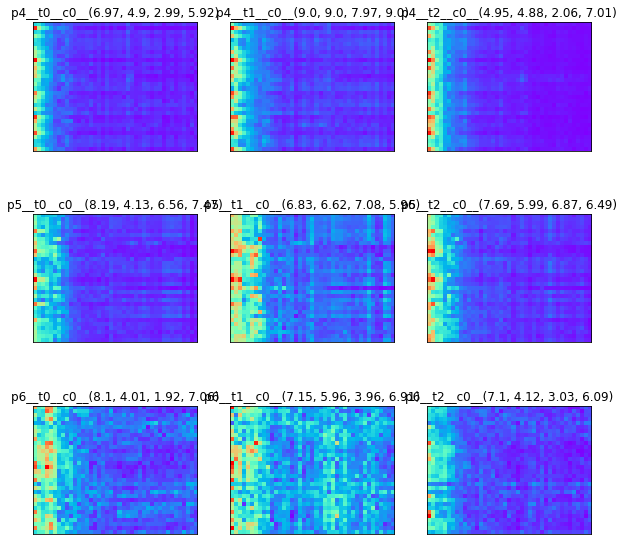

In [7]:
# plot settings
idx = 0
base = (3, 3) 
plt.figure(figsize=(10, 10))

for i in idx_list:
    p_id, t_id, c_id = from_data_index(i, noc)
    base_index = get_base_index(p_id, t_id)
    
    if data_type == "fftMap":
        plotData = data_list[i][0]
        x_y = idx//base[1], idx%base[1]
        plt.subplot2grid(base, x_y)
        plt.title("p" + str(p_id) + "__t" + str(t_id) + "__c" + str(c_id) +"__"+str(data_list[i][1]))
        fig = plt.imshow(plotData, cmap='rainbow')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        idx += 1
        
    elif data_type == "fd":
        head_plot(data_list[i][0]) # base_fd_list, diff

### Average plot

#### Initialization

In [8]:
if dataset == "SEED":
    numOfParticipants = 15
    emotions = ["negative", "neutral", "positive"]
    
    
elif dataset == "DEAP":
    numOfParticipants = 32
    VAD_map = {"LHL":"frightened", "LHH":"angry", "HHH" : "happy", "HHL" : "surprise",
              "HLL" : "protected", "HLH" : "satisfied", "LLH" : "unconcerned", "LLL" : "sad"}
    # 각 감정별로 몇개의 데이터가 있는지 카운트
    emotions = ["frightened", "angry", "happy", "surprise",
              "protected", "satisfied", "unconcerned", "sad"]

# count how many per emotion
emo_count = {}
# add all computed values per emotion (to compute average value)
emo_value = {}
# add all base values per emotion
base_emo_value = {}

for emotion in emotions:
    emo_count[emotion] = 0
    if data_type == "fftMap": init = np.zeros((data_list[0][0].shape[0], data_list[0][0].shape[1]))
    elif data_type == "fd": init = np.zeros((len(data_list[0][0])))
    emo_value[emotion] = init
    base_emo_value[emotion] = init

# add all values per participant
subject_value = {}
base_subject_value = {}

for p_id in range(0,numOfParticipants):
    if data_type == "fftMap": init = np.zeros((data_list[0][0].shape[0], data_list[0][0].shape[1]))
    elif data_type == "fd": init = np.zeros((len(data_list[0][0])))
    subject_value[p_id] = init
    base_subject_value[p_id] = init

#### Traverse

In [9]:
for idx in range(len(data_list)): 
    p_id, t_id, c_id = from_data_index(idx, noc)
    base_idx = get_base_index(p_id, t_id)
    
    if dataset == "SEED":
        label = data_list[idx][1] 
        emo = emotions[label]
    elif dataset == "DEAP":
        V,A,D,L = data_list[idx][1]
        V = 'H' if V > 5 else 'L'; A = 'H' if A > 5 else 'L';
        D = 'H' if D > 5 else 'L'; L = 'H' if L > 5 else 'L';
        emo = VAD_map[V+A+D]        
    
    emo_count[emo]+=1
        
    val = data_list[idx][0] 
    # base_val = base_list[base_idx]
    
    # scale channel by channel (option)
    # for ch in range(0,len(chosen_channels)): val[ch] = scale(val[ch])
    
    emo_value[emo] += val
    # base_emo_value[emo] += base_val
    
    # 아 이건 에바다..인데스 파일 수정좀 ****
    if dataset == "SEED": subject_value[p_id-1] += val
    else: subject_value[p_id] += val

    # base_subject_value[p_id] += base_val        
print(emo_count)

{'frightened': 8823, 'angry': 6375, 'happy': 19278, 'surprise': 3111, 'protected': 3978, 'satisfied': 9741, 'unconcerned': 4386, 'sad': 9588}


### Plot per emotion

In [11]:
idx = 0
base = (1,3) if dataset == "SEED" else (4,2)
plt.figure(figsize=(10,10))

for emo, cnt in emo_count.items():
    if data_type == "fftMap":
        x_y = idx//base[1], idx%base[1]
        plt.subplot2grid(base, x_y)
        plt.title(emo)
        fig = plt.imshow(emo_value[emo], cmap='rainbow')
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
        idx += 1
    elif data_type == "fd":
        print(emo)
        head_plot(emo_value[emo])

### Plot per subject

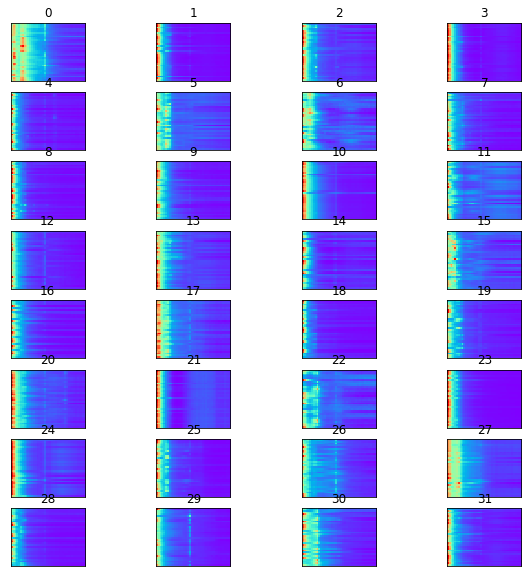

In [12]:
idx = 0
base = (3, 5) if dataset == "SEED" else (8, 4)
plt.figure(figsize=(10,10))

for p_id in range(0, numOfParticipants):
    if data_type == "fftMap":
        x_y = idx//base[1], idx%base[1]
        plt.subplot2grid(base, x_y)
        plt.title(p_id)
        fig = plt.imshow(subject_value[p_id], cmap='rainbow')
        fig.axes.get_xaxis().set_visible(False); fig.axes.get_yaxis().set_visible(False)
        idx += 1
    elif data_type == "fd":
        head_plot(subject_value[p_id])